Installing postgres using Homebrew.  
https://www.dataquest.io/blog/install-postgresql-14-7-for-macos/?_gl=1*1vrbtn6*_gcl_au*NjQ1OTI0MzQxLjE3MTYyNzUyMDY.

# NorthWind Traders Data Analysis

In [146]:
%load_ext sql
%sql postgresql://postgres@localhost:5432/northwind

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [147]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use("seaborn-v0_8-colorblind")

In [148]:
%%sql --only use this line if running in Jupyter Notebook
SELECT table_name AS name,
       table_type AS type
  FROM information_schema.tables
 WHERE table_schema = 'public' AND table_type IN ('BASE TABLE', 'VIEW');

 * postgresql://postgres@localhost:5432/northwind
14 rows affected.


name,type
territories,BASE TABLE
order_details,BASE TABLE
employee_territories,BASE TABLE
us_states,BASE TABLE
customers,BASE TABLE
orders,BASE TABLE
employees,BASE TABLE
shippers,BASE TABLE
products,BASE TABLE
categories,BASE TABLE


In [149]:
%%sql -- orders and customers
SELECT 
    O.order_id, O.order_date, O.ship_country, O.customer_id
FROM
    orders O
INNER JOIN customers C ON O.customer_id = C.customer_id
LIMIT 5 

 * postgresql://postgres@localhost:5432/northwind
5 rows affected.


order_id,order_date,ship_country,customer_id
10248,1996-07-04,France,VINET
10249,1996-07-05,Germany,TOMSP
10250,1996-07-08,Brazil,HANAR
10251,1996-07-08,France,VICTE
10252,1996-07-09,Belgium,SUPRD


In [150]:
%%sql -- orders, order_details, products
SELECT
    O.order_date, O.order_id, 
    OD.product_id, OD.unit_price, OD.quantity, OD.discount,
    P.product_name, P.category_id
FROM orders O
INNER JOIN order_details OD ON O.order_id=OD.order_id
INNER JOIN products P ON OD.product_id=P.product_id
LIMIT 5

 * postgresql://postgres@localhost:5432/northwind
5 rows affected.


order_date,order_id,product_id,unit_price,quantity,discount,product_name,category_id
1996-07-04,10248,11,14.0,12,0.0,Queso Cabrales,4
1996-07-04,10248,42,9.8,10,0.0,Singaporean Hokkien Fried Mee,5
1996-07-04,10248,72,34.8,5,0.0,Mozzarella di Giovanni,4
1996-07-05,10249,14,18.6,9,0.0,Tofu,7
1996-07-05,10249,51,42.4,40,0.0,Manjimup Dried Apples,7


In [151]:
%%sql -- employees and orders
SELECT
    E.employee_id, E.hire_date, E.title,
    O.order_id
FROM employees E
INNER JOIN orders O ON E.employee_id=O.employee_id
ORDER BY 1
LIMIT 5

 * postgresql://postgres@localhost:5432/northwind
5 rows affected.


employee_id,hire_date,title,order_id
1,1992-05-01,Sales Representative,10258
1,1992-05-01,Sales Representative,10270
1,1992-05-01,Sales Representative,10275
1,1992-05-01,Sales Representative,10285
1,1992-05-01,Sales Representative,10292


## Sales Performance Based on Employees Performance  
### Total Sales per Employee

In [152]:
query = """
SELECT
    E.employee_id, E.first_name || ' ' || E.last_name AS name, E.title,
    ROUND( SUM(OD.unit_price * OD.quantity * (1-OD.discount))::numeric, 0) AS total_sales
FROM
    employees E
INNER JOIN orders O ON E.employee_id = O.employee_id
INNER JOIN order_details OD ON O.order_id = OD.order_id
GROUP BY E.employee_id
ORDER BY total_sales DESC
"""
result = %sql $query
employee_sales = pd.DataFrame(result)
employee_sales

 * postgresql://postgres@localhost:5432/northwind
9 rows affected.


,employee_id,name,title,total_sales
0,4,Margaret Peacock,Sales Representative,232891
1,3,Janet Leverling,Sales Representative,202813
2,1,Nancy Davolio,Sales Representative,192108
3,2,Andrew Fuller,"Vice President, Sales",166538
4,8,Laura Callahan,Inside Sales Coordinator,126862
5,7,Robert King,Sales Representative,124568
6,9,Anne Dodsworth,Sales Representative,77308
7,6,Michael Suyama,Sales Representative,73913
8,5,Steven Buchanan,Sales Manager,68792


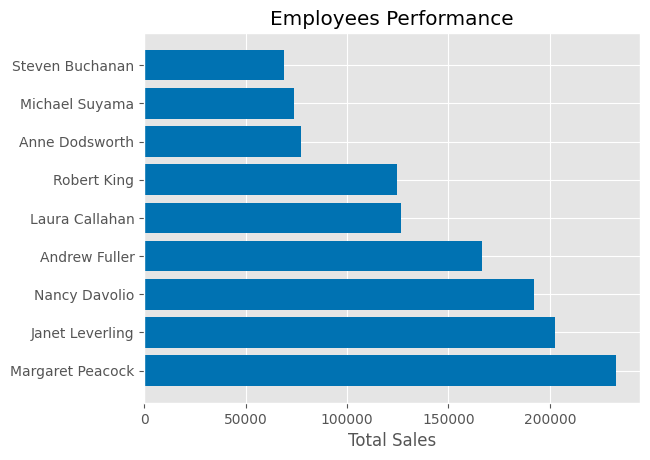

In [153]:
%matplotlib inline
plt.barh(employee_sales["name"], employee_sales["total_sales"])
plt.xlabel("Total Sales")
plt.title("Employees Performance")
plt.show()

In [154]:
%%sql -- Adding Ranking
SELECT *,
    RANK() OVER(ORDER BY total_sales DESC 
                ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS rank
FROM (
    SELECT
        E.employee_id, E.first_name || ' ' || E.last_name AS name, E.title,
        ROUND( SUM(OD.unit_price * OD.quantity * (1-OD.discount))::numeric, 0) AS total_sales
    FROM
        employees E
    INNER JOIN orders O ON E.employee_id = O.employee_id
    INNER JOIN order_details OD ON O.order_id = OD.order_id
    GROUP BY E.employee_id
    ORDER BY total_sales DESC
) AS sub

 * postgresql://postgres@localhost:5432/northwind
9 rows affected.


employee_id,name,title,total_sales,rank
4,Margaret Peacock,Sales Representative,232891,1
3,Janet Leverling,Sales Representative,202813,2
1,Nancy Davolio,Sales Representative,192108,3
2,Andrew Fuller,"Vice President, Sales",166538,4
8,Laura Callahan,Inside Sales Coordinator,126862,5
7,Robert King,Sales Representative,124568,6
9,Anne Dodsworth,Sales Representative,77308,7
6,Michael Suyama,Sales Representative,73913,8
5,Steven Buchanan,Sales Manager,68792,9


## Company's Overall Sales Performance  
### Visualization on Running Total Sales by Month

In [155]:
query = """
WITH truncated AS (
    SELECT order_id, DATE_TRUNC('month', order_date) AS date
    FROM orders
)

SELECT
    EXTRACT(YEAR FROM T.date) || '-' || EXTRACT(MONTH FROM T.date) AS month,
    ROUND(SUM(SUM(OD.unit_price * OD.quantity * (1-OD.discount))) 
          OVER(ORDER BY T.date)::numeric, 0) AS RunningTotal
FROM truncated T
INNER JOIN order_details OD ON T.order_id = OD.order_id
GROUP BY T.date
"""

result = %sql $query
running_total = pd.DataFrame(result)
running_total

 * postgresql://postgres@localhost:5432/northwind
23 rows affected.


,month,runningtotal
0,1996-7,27862
1,1996-8,53347
2,1996-9,79729
3,1996-10,117244
4,1996-11,162844
5,1996-12,208084
6,1997-1,269342
7,1997-2,307826
8,1997-3,346373
9,1997-4,399406


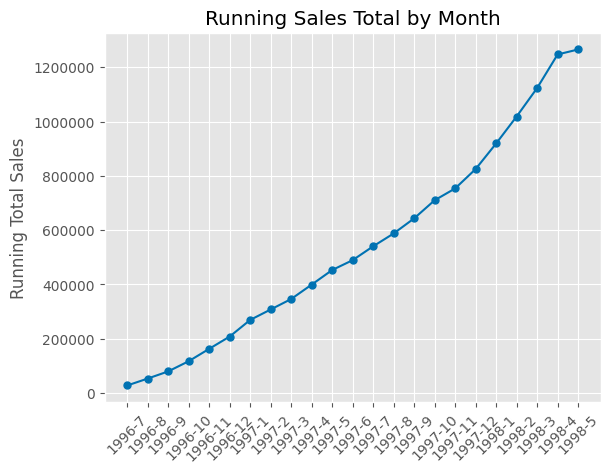

In [158]:
plt.plot('month', 'runningtotal', marker='o', markersize=5, data=running_total)
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
plt.ylabel("Running Total Sales")
plt.title("Running Sales Total by Month")
plt.show()